# Basics of running `tifuun-sensitivity`. 

In this tutorial for `tifuun-sensitivity`, we will discuss how to use the program. It is divided into three sections:
- Defining input structures and parameters.
- Running a calculation.
- Understanding the output format.

First, we discuss the input structures. We will define the telescope and instrument. Then, we will discuss an important input: the radiative transfer cascade. Lastly, we discuss some other input parameters that pertain to details unrelated to the telescope, instrument, or cascade, which are important for calculating some output quantities. 

After that, we show quickly how to use the `tifuun-sensitivity` package and how to call the relevant functions.

Finally, we discuss the output given by `tifuun-sensitivity`.

Throughout this tutorial, we will use parameters of DESHIMA 2.0.

## Part 1: input to calculation

The telescope and instrument are defined using dictionaries. These dictionaries have the same structure as the input dictionaries for the `gateau` package (the end-to-end simulator for TIFUUN). However, the required parameters only form a subset of the `gateau` input since the sensitivity calculation is significantly more simple than the full simulation. We will now describe each dictionary in detail.

### Telescope dictionary

The important parameters for the telescope are: diameter, RMS surface roughness, aperture efficiency, and elevation. These should be assigned to a dictionary, where the field names should be as in the following example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifuun_sensitivity.simulator import calculator

diameter  = 10    # Diameter, units: m
s_rms     = 42e-6 # RMS surface roughness, units: m
eta_taper = 0.7   # Taper efficiency at zero frequency (so not including Ruze efficiency), units: none
EL0       = 60    # Elevation angle of telescope with respect to the horizon, units: degrees

telescope = {
    "D_tel"      : diameter,
    "s_rms"      : s_rms,
    "eta_taper"  : eta_taper,
    "EL0"        : EL0,
}

Note that we also put the imports here for `numpy`, `matplotlib`, and `tifuun-sensitivity`. We will need these later on.

### Instrument dictionary

The instrument is quite important, as this sets the response curves for the filterbank. Currently, these can be Lorentzians, or measured shapes loaded from a file. 

If a Lorentzian filterbank is required, the resolving power and central channel frequencies should be passed. Additionally, the in-band fraction should be given. This is a number specifying how much of the filter couples to line emission and continuum emission. This number is usually 0.5, meaning that continuum emission loads a filter shape more by about a factor 2. Since it is really not a necessity of `gateau` to calculate different coupling efficiencies for line and continuum, this factor is unique for `tifuun-sensitivity`. Another, optional, parameter is the KID excess noise factor. If this is not given, it is set to 1 for the calculation. This factor is also unique to `tifuun-sensitivity`.

An instrument dictionary with a Lorentzian filterbank is specified as follows:

In [2]:
f0 = 220 * 1e9
nf = 350
R = 500

f_ch = f0 * (1 + 1/R)**np.arange(nf) 

instrument = {
    "f_ch"    : f_ch, # Channel frequencies in GHz
    "R"       : R,    # Resolving power
    "eta_IBF" : 0.5, # in-band fraction
    "KID_excess_noise_factor" : 1.1
}

For a custom filterbank, the `"f_ch"` field should contain a `numpy` array with the center frequencies of each filter, in units of Hz. The `"R"` field should contain a `numpy` array with shape `(2,N)`, with the first column containing the frequencies at which the filterbank has been measured in GHz, and the second column contains the filter shapes. Note that, if the measured filters have not been normalised (and thus contain the transmission coefficient as well), the final efficiency in the cascade (which couples to the filterbank) should be set at 1. We will come back to this when discussing the cascade in the next section.

Note that, when working from Lorentzian filterbanks, `tifuun-sensitivity` will calculate the frequency points at which to evaluate the filterbank for you. That's why this does not need to be passed when generating the filterbank from a single "R" value.

### Cascade List

The cascade list is a list containing dictionaries. Each of these dictionaries defines a radiative transfer stage of the cascade, where the incoming radiation is attenuated by a specific efficiency term pertaining to the stage, and radiation is added due to the emissivity of the stage. In formula form:
$$P_{\nu,\mathrm{out}} = \eta_\mathrm{stage} P_{\nu,\mathrm{in}} + (1 - \eta_\mathrm{stage}) P_{\nu,\mathrm{stage}},$$
where $P_{\nu,\mathrm{out}}$ is the power spectral density of the outgoing radiation, $\eta_\mathrm{stage}$ the efficiency term associated with this stage, $P_{\nu,\mathrm{in}}$ the power spectral density of the incoming radiation, and $P_{\nu,\mathrm{stage}}$ the single-moded Johnson-Nyquist power spectral density of the radiation emitted by the stage itself, which we will often refer to as the 'parasitic' source.

A dictionary for a single stage can be divided into two types: a **reflective stage**, where light solely reflects off the stage as is the case for, for example, spillover losses or Ohmic losses, or a **refractive stage**, which is the case for cryostat windows and lenses. Note that refractive stages could also contain reflective stages if they are not AR coated. We will start by discussing reflective stages.

#### Reflective cascade stages
These require two dictionary fields: one containing the efficiency of the stage, named "eta_coup", and one containing the physical temperature of the parasitic source, named "T_parasitic". Let's say we would like to include spillover losses on the primary reflector of the telescope. Let's assume the spillover efficiency is 0.99. Also, the part of the beam that spills over will couple to the ground, which has a physical temperature of 273 K (for example). The dictionary would look like this:

In [3]:
cascade_list = []

primary_spillover = {
    "eta_coup"     : 0.99,
    "T_parasitic"  : 273
}

cascade_list.append(primary_spillover)

Now, say this primary reflector is made out of aluminium. Therefore, Ohmic losses should be included. This can be done by defining a new stage.

In [4]:
primary_Ohmic = {
    "eta_coup"     : "Ohmic-Al",
    "T_parasitic"  : 273
}

cascade_list.append(primary_Ohmic)

By passing "Ohmic-Al" as "eta_coup", it tells `tifuun-sensitivity` to use the efficiency of aluminium. This is calculated from measured values at 850 GHz, and converted to the range used by the filterbank. 

The next stage would be the secondary mirror. We will assume a spillover efficiency of 0.9 for this. However, the part of the beam that spills over does not couple to 273 K now, but rather directly to the atmosphere. The atmosphere power spectral density has a rather complex shape that cannot be parameterised by a single temperature and hence needs a special way of incorporating. This can be done in the following way:

In [5]:
secondary_spillover = {
    "eta_coup"     : 0.9,
    "T_parasitic"  : "atmosphere"
}

cascade_list.append(secondary_spillover)

This tells `tifuun-sensitivity` that it should use the atmosphere power spectral density in this stage as the parasitic source. This is calculated already in the beginning of the cascade using the physical temperature of the atmosphere and the precipitable water vapor (pwv) (see next subsectuion on inputs) and the `ATM` model to calculate transmission of the atmosphere as function of frequency and pwv.

#### Refractive stages
Aside from stages coupling through spillover or reflections, there are also objects such as cryostat windows or lenses, which transmit the light through a dielectric. In this example, we define a silicon lens and the HDPE cryostat window. These are passed to `tifuun-sensitivity` in the following way:

In [6]:
lens = {
    "thickness"        : 40e-3, # Lens thickness in meters
    "tandelta"         : 1.3e-4,
    "neff"             : 3.4, # Effective refractive index of silicon - air interface
    "AR"               : True, # Whether to use anti-reflective coating
    "T_parasitic_refl" : 290, # Parasitic source seen in reflection of window in K, here take cabin temperature
    "T_parasitic_refr" : 290 # Parasitic source seen when transmitting through window, which we take as cabin temperature as well.
}

cascade_list.append(lens)

cryo_window = {
    "thickness"        : 8e-3, # Window thickness in meters
    "tandelta"         : 4.805e-4,
    "neff"             : 1.52, # Effective refractive index of HDPE - air interface
    "AR"               : True, # Whether to use anti-reflective coating
    "T_parasitic_refl" : 4, # Parasitic source seen in reflection of window in K, here take cryostat
    "T_parasitic_refr" : 290, # Parasitic source seen when transmitting through window, which we take as cabin temperature.
    "cryo_window_flag" : True # Here we say that this refractive stage is the cryostat window
}

cascade_list.append(cryo_window)

Here, we pass different parameters compared to the reflective stage. It is important to see that there are now two sources per stage that are coupled to: one by reflections off the window/lens, and one representing the coupling to the interior of the dielectric. Also important is that we set the "cryo_window_flag" to `True` on the stage representing the cryostat window. Every cascade needs **exactly one cryostat window**, otherwise the code will not work!

#### IMPORTANT! Always end on a reflective stage!
Because of how the program is designed, the last stage should be a reflective one. In this case, we will use the DESHIMA 2.0 filter transmission and we will let it couple to the chip at 120 mK:

In [7]:
circuit = {
    "eta_coup"     : 0.16,
    "T_parasitic"  : 0.12
}

cascade_list.append(circuit)

### Other input parameters

Aside from the input dictionaries, `tifuun-sensitivity` requires a couple of other input parameters. These are passed separately, because they do not depend on the telescope or instrument, but rather on the atmosphere and observation length or requirements. the extra parameters are:

In [8]:
PWV = 0.5 # Precipitable water vapor, units: mm
Tb_cmb = 2.725 # CMB temperature, units: K
Tp_atm = 273 # Physical temperature of atmosphere, units: K
snr = 5 # Signal-to-noise required for a line to be detectable. Used for calculating MDLF. Units: none
obs_hours = 1 # Number of hours spent observing.Used for calculating MDLF.
on_source_fraction = 0.4 * 0.9 # How much of the scanning time is actually spent on-source. This also reflects chopping.
on_off = True # Whether or not to perform sky chopping

## Running the calculation

After defining all input parameters, it is really simple to start the calculation:

In [9]:
out_dict = calculator(cascade_list, 
                      telescope, 
                      instrument,
                      PWV,
                      Tb_cmb,
                      Tp_atm,
                      snr,
                      obs_hours,
                      on_source_fraction,
                      on_off)

## Using the output

The output of a calculation is stored inside a dictionary. The following table summarizes the output fields. Also note that the **Name** column contains the actual name of the field: quering this name in the dictionary fetches the values.

| Name | Description | Units |
| ---- | ----------- | ----- |
| F_KID | Center frequencies of filters | Hz |
| F_sky | Sky frequencies over which the filters are evaluated | Hz |
| El | Elevation at which sensitivity is calculated | degree |
| PWV | Precipitable water vapor for calculation | mm |
| R | Resolving power of filterbank | none |
| filterbank | 2D numpy array containing filterbank (F_sky along axis 0, F_KID along axis 1) | none |
| W_F_spec | Equivalent width of each filter when coupling to a single line inside filter | Hz |
| W_F_cont | Equivalent width of each filter when coupling to continuum | Hz |
| eta_atm | Transmission coefficient of atmosphere for each F in F_KID, averaged over filter shape | none |
| eta_ap | Aperture efficiency for each F in F_KID, averaged over filter shape | none |
| eta_fwd | Forward efficiency for each F in F_KID, averaged over filter shape | none |
| eta_sw | Source-window coupling for each F in F_KID, averaged over filter shape | none |
| eta_window | Cryostat window transmission for each F in F_KID, averaged over filter shape | none |
| eta_inst | Instrument efficiency (from window to circuit) for each F in F_KID, averaged over filter shape | none |
| Tb_sky | Atmosphere brightness temperature, averaged over filtershape | K |
| psd_KID | Power spectral density seen by a KID, averaged over filtershape | W / Hz |
| P_KID | Power received by a KID | W |
| NEP_KID | Noise equivalent power for each KID | W / Hz$^{1/2}$ |
| NEP_inst | Noise equivalent power for each KID, divided by eta_sw | W / Hz$^{1/2}$ |
| NET_sky | Noise equivalent temperature, evaluated before atmosphere, for each KID | K s$^{1/2}$ |
| NEFD_line | Noise equivalent flux density for each KID, for line emission | W / m$^2$ / beam / Hz$^{1/2}$ |
| NEFD_continuum | Noise equivalent flux density for each KID, for continuum emission | W / m$^2$ / beam / Hz$^{1/2}$ |
| MDLF | Minimum detectable line flux for each KID | W / m$^2$ |
| equivalent_Trx | Receiver noise temperature | K |
| n_ph | Photon occupation number | none (number of photons per coherence time) |

Now lets plot some output. For this example, we plot the NEP, NET and NEFD.

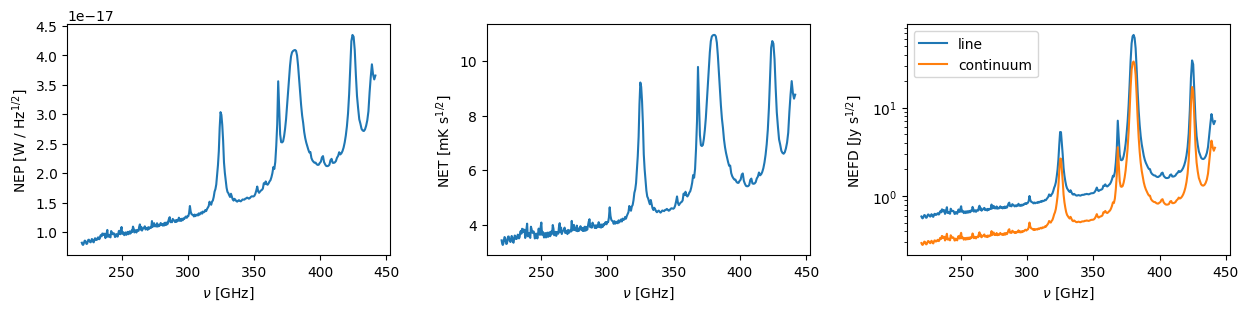

In [10]:
NEP = out_dict["NEP_KID"]
NET = out_dict["NET_sky"]
NEFD_line = out_dict["NEFD_line"]
NEFD_cont = out_dict["NEFD_continuum"]
F_KID = out_dict["F_KID"] / 1e9

fig, ax = plt.subplots(1,3, figsize=(15,3), gridspec_kw={"wspace":0.3})

ax[0].plot(F_KID, NEP)
ax[0].set_xlabel(r"$\nu$ [GHz]")
ax[0].set_ylabel(r"NEP [W / Hz$^{1/2}$]")
ax[1].plot(F_KID, NET*1000)
ax[1].set_xlabel(r"$\nu$ [GHz]")
ax[1].set_ylabel(r"NET [mK s$^{1/2}$]")
ax[2].plot(F_KID, NEFD_line * 1e26, label="line")
ax[2].plot(F_KID, NEFD_cont * 1e26, label="continuum")
ax[2].set_yscale('log')
ax[2].set_xlabel(r"$\nu$ [GHz]")
ax[2].set_ylabel(r"NEFD [Jy s$^{1/2}$]")
ax[2].legend()
plt.show()

Or, we could plot the total received power:

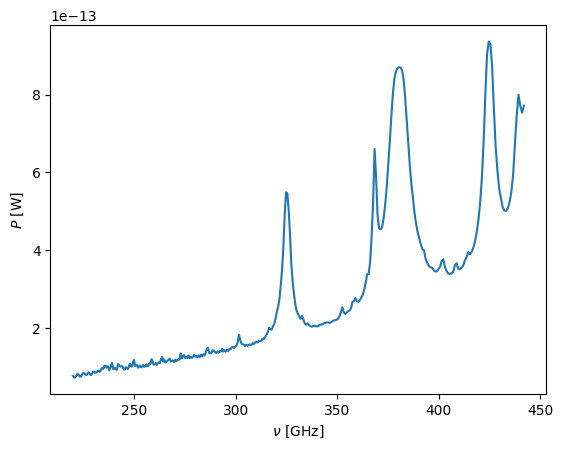

In [11]:
P_KID = out_dict["P_KID"]

plt.plot(F_KID, P_KID)
plt.xlabel(r"$\nu$ [GHz]")
plt.ylabel(r"$P$ [W]")
plt.show()

It is also possible to plot efficiencies. For example, let's plot the following:
 - calculated transmission of the cryostat window
 - forward efficiency, starting from the cryostat window
 - instrument efficiency, from chip up to and including the window
 - aperture efficiency

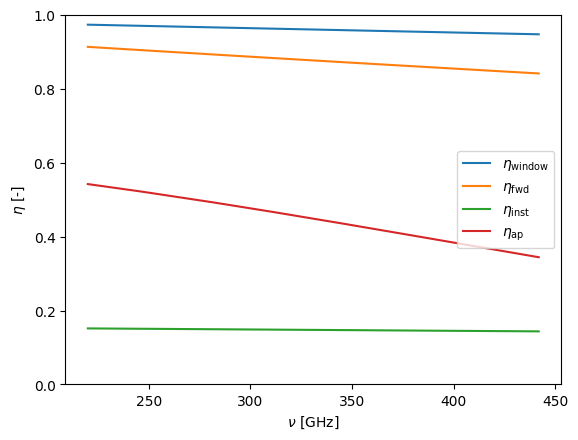

In [12]:
plt.plot(F_KID, out_dict["eta_window"], label=r"$\eta_\mathrm{window}$")
plt.plot(F_KID, out_dict["eta_fwd"], label=r"$\eta_\mathrm{fwd}$")
plt.plot(F_KID, out_dict["eta_inst"], label=r"$\eta_\mathrm{inst}$")
plt.plot(F_KID, out_dict["eta_ap"], label=r"$\eta_\mathrm{ap}$")
plt.ylim(0,1)
plt.xlabel(r"$\nu$ [GHz]")
plt.ylabel(r"$\eta$ [-]")
plt.legend()
plt.show()

In fact, you can plot anything contained within the output dictionary!